**Univariate** time series forecasting with LSTM

https://www.youtube.com/watch?v=CbTU92pbDKw

https://www.youtube.com/watch?v=c0k-YLQGKjY

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
dates_to_dt = ['Date']
df = pd.read_csv('C:/Users/tomwr/Desktop/data_science_projects/RNN work/microsoft_stocks/MSFT.csv',
                parse_dates = dates_to_dt)

In [3]:
print(df.head(3))
print(df.info())

        Date      Open      High       Low     Close  Adj Close      Volume
0 1986-03-13  0.088542  0.101563  0.088542  0.097222   0.061109  1031788800
1 1986-03-14  0.097222  0.102431  0.097222  0.100694   0.063292   308160000
2 1986-03-17  0.100694  0.103299  0.100694  0.102431   0.064384   133171200
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9137 entries, 0 to 9136
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       9137 non-null   datetime64[ns]
 1   Open       9137 non-null   float64       
 2   High       9137 non-null   float64       
 3   Low        9137 non-null   float64       
 4   Close      9137 non-null   float64       
 5   Adj Close  9137 non-null   float64       
 6   Volume     9137 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 499.8 KB
None


#Remove other columns and set **Date** column as the index. Also going to create a date numpy array for future use (graphs)

In [4]:
df = df [['Date', 'Close']]
date_values = df['Date'].values.copy()
df = df.set_index('Date')
print(df.head(3))

               Close
Date                
1986-03-13  0.097222
1986-03-14  0.100694
1986-03-17  0.102431


Plot the Close value over time

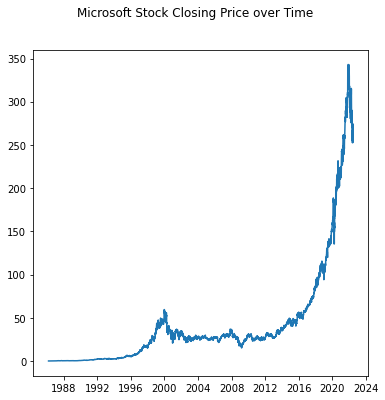

In [5]:
plt.figure(figsize = (6,6))
plt.suptitle('Microsoft Stock Closing Price over Time')
plt.plot(df.index, df['Close'])
plt.show()

Split the dataframe into features (X) and labels (y).

**Features** will be the closing stock price for the previous WINDOW_SIZE days.

**Labels** will be the actual closing stock price for that day

In [6]:
def df_to_X_y(df, window_size):
    
    df_as_np = df.to_numpy()
    X = []
    y = []
    
    for i in range(len(df_as_np) - window_size):
        features = [[a] for a in df_as_np[i : i + window_size]] # will form all but 1 column in each row
        X.append(features)
        
        label = df_as_np[i + window_size] # forms 1 column in each row at the end = original
        y.append(label)
        
    return np.array(X), np.array(y)

Splitting the df into **X and y** - (features and labels)

In [7]:
WINDOW_SIZE = 4
X, y = df_to_X_y(df, WINDOW_SIZE)

#Remove 1 dimension
X = tf.squeeze(X, axis = [3])
y = tf.squeeze(y, axis = [1])

print('\nX shape: ', X.shape)
print('\ny shape: ', y.shape)


X shape:  (9133, 4, 1)

y shape:  (9133,)


Split **X and y** into **training, validation, test sets.**  - Roughly **80:10:10**

In [19]:
#X_train, y_train = X[:7500], y[:7500] # start to 7499
#X_val, y_val = X[7500:8250], y[7500:8250] # 7500 (inc) to 8249
#X_test, y_test = X[8250:], y[8250:] # 8250 to the end

#Making a larger training set due to rapid increase at later dates - This performed worse (?)
X_train, y_train = X[:8000], y[:8000]
X_val, y_val = X[8000:8650], y[8000:8650]
X_test, y_test = X[8650:], y[8650:]

print('\nfeatures:')
print('\nX_train shape: ', X_train.shape)
print('\nX_val shape: ', X_val.shape)
print('\nX_test shape: ', X_test.shape)

print('')

print('\nlabels:')
print('\ny_train shape: ', y_train.shape)
print('\ny_val shape: ', y_val.shape)
print('\ny_test shape: ', y_test.shape)


features:

X_train shape:  (8000, 4, 1)

X_val shape:  (650, 4, 1)

X_test shape:  (483, 4, 1)


labels:

y_train shape:  (8000,)

y_val shape:  (650,)

y_test shape:  (483,)


Import Modules for a Model

In [20]:
from keras.models import Sequential
from keras.layers import * # all
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

Create model architecture

In [21]:
EPOCHS = 25

model = Sequential()
model.add(InputLayer((WINDOW_SIZE, 1)))
model.add(LSTM(units = 32, return_sequences = True))
model.add(LayerNormalization())
model.add(LSTM(units = 32, return_sequences = True))
model.add(LayerNormalization())
model.add(LSTM(units = 32, return_sequences = False))
model.add(Dense(32, 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(16, 'relu'))
model.add(BatchNormalization())
model.add(Dense(1, 'linear'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 4, 32)             4352      
_________________________________________________________________
layer_normalization_2 (Layer (None, 4, 32)             64        
_________________________________________________________________
lstm_4 (LSTM)                (None, 4, 32)             8320      
_________________________________________________________________
layer_normalization_3 (Layer (None, 4, 32)             64        
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)               

**Create callbacks**

In [22]:
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(monitor = 'val_root_mean_squared_error',
                                                 patience = 5)

model_checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath = 'C:/Users/tomwr/Desktop/data_science_projects/RNN work/microsoft_stocks/saved_models',
                                                     save_best_only = True,
                                                     monitor = 'val_loss')

**Compile and fit model**

In [23]:
model.compile(loss = MeanSquaredError(), optimizer = Adam(), metrics = [RootMeanSquaredError()])

history = model.fit(X_train, y_train,
         validation_data = (X_val, y_val),
         epochs = EPOCHS,
         callbacks = [reduce_lr_cb, model_checkpoint_cb])

Epoch 1/25
250/250 [==============================] - 46s 183ms/step - loss: 581.4435 - root_mean_squared_error: 24.1131 - val_loss: 14570.2910 - val_root_mean_squared_error: 120.7075
Epoch 2/25
250/250 [==============================] - 39s 155ms/step - loss: 333.7721 - root_mean_squared_error: 18.2694 - val_loss: 6682.7129 - val_root_mean_squared_error: 81.7479
Epoch 3/25
250/250 [==============================] - 43s 174ms/step - loss: 169.6531 - root_mean_squared_error: 13.0251 - val_loss: 1988.0066 - val_root_mean_squared_error: 44.5871
Epoch 4/25
250/250 [==============================] - 37s 149ms/step - loss: 66.5310 - root_mean_squared_error: 8.1567 - val_loss: 1032.5992 - val_root_mean_squared_error: 32.1341
Epoch 5/25
250/250 [==============================] - 37s 148ms/step - loss: 27.9352 - root_mean_squared_error: 5.2854 - val_loss: 552.8292 - val_root_mean_squared_error: 23.5123
Epoch 6/25
250/250 [==============================] - 1s 6ms/step - loss: 17.8741 - root_mean

**Plot some model metrics from training**

In [24]:
def plot_model_metrics_training(history, roll_avg_win):
    history_df = pd.DataFrame(history.history)
    no_epochs = len(history_df['loss'])
    x_axis = np.arange(1, no_epochs + 1, 1)
    
    plt.figure(figsize = (10,10))
    plt.suptitle('Training metrics')
    plt.plot(history_df['loss'], label = 'Training Loss')
    plt.plot(history_df['val_loss'], label = 'Validation Loss')
    plt.plot(history_df['val_loss'].rolling(window = roll_avg_win).mean(),
             label = f'Validation Loss Rolling Average (Window = {roll_avg_win})')
    
    plt.plot(history_df['root_mean_squared_error'], label = 'RMSE')
    plt.plot(history_df['val_root_mean_squared_error'], label = 'Validation RMSE')
    plt.xlabel('Epochs')
    plt.yscale('log')
    plt.legend()
    plt.show()


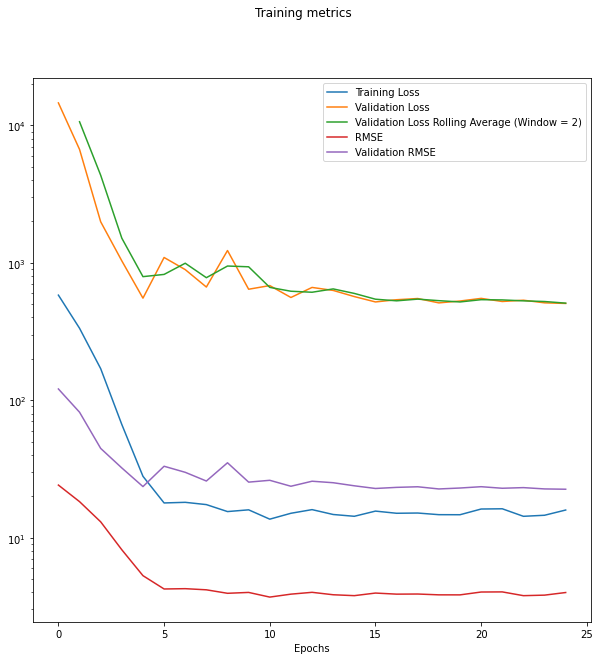

In [25]:
plot_model_metrics_training(history, 2)

**Display some predictions** - created a function for it - only plots against itself

In [26]:
def predict_and_plot_observed_graph(model, features, labels, type_pred):
    plt.figure(figsize = (8,8))
    
    predictions = model.predict(features).flatten()
    
    plt.suptitle(f'Model predictions on the {type_pred} set')
    
    plt.plot(predictions)
    plt.plot(labels)
    plt.legend(['Predictions', 'Observed'])
    plt.show()

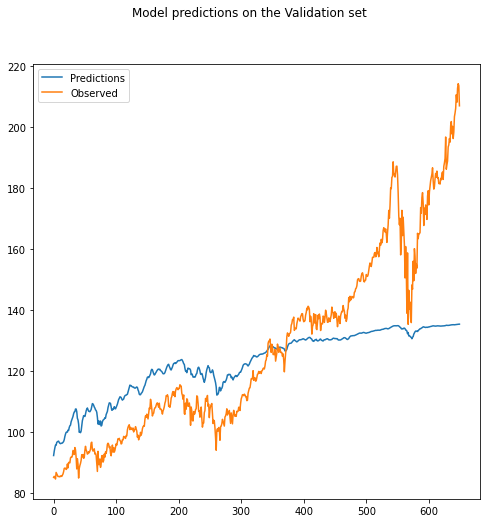

In [27]:
predict_and_plot_observed_graph(model, X_val, y_val, 'Validation')

**Function to create a dataframe of predictions vs observed and residual size**

In [28]:
def plot_predicted_vs_observed_and_residual(model, features, labels, type_pred):
    
    predictions = model.predict(features).flatten()
    
    results_df = pd.DataFrame(data = {'Predictions': predictions, 'Observed': labels, 
                                      'Residuals': labels - predictions})
    plt.figure(figsize = (10,10))
    plt.suptitle(f'Predicted vs. Actual values and residual of {type_pred} dataset')
    plt.plot(results_df['Predictions'])
    plt.plot(results_df['Observed'])
    plt.plot(results_df['Residuals'])
    plt.legend(['Predictions', 'Observed', 'Residual'])
    
    plt.show()

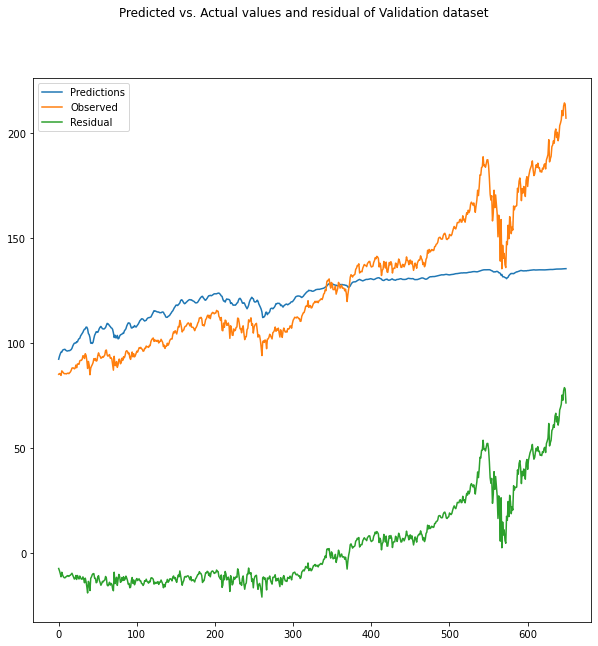

In [29]:
plot_predicted_vs_observed_and_residual(model, X_val, y_val, 'Validation')